<a href="https://colab.research.google.com/github/EdwinZhanCN/Lab-1/blob/main/01_datasheet_and_audit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
%pip install kagglehub pandas numpy matplotlib seaborn scikit-learn

## Dataset Preparation
First,we identify all columns and drop columns with no enough rows. And we drop all rows that has no enough columns.

In [5]:
import kagglehub
import pandas as pd
import os

# Download latest version
path = kagglehub.dataset_download("kemical/kickstarter-projects")
csv_file = [f for f in os.listdir(path) if f.endswith(".csv")][0]
df=pd.read_csv(os.path.join(path, csv_file))

# Identify all unique columns
unique_columns = []
for column in df.columns:
    unique_columns.append(column)
print(unique_columns)

# Drop unsatisified columns
df_clean = df.drop(columns=['ID', 'usd_pledged_real', 'usd_goal_real'])
# Drop all rows that does not have 'usd pledged'
df_leak = df_clean.dropna(subset=['usd pledged']).copy()
display(df_leak.head(5))


Using Colab cache for faster access to the 'kickstarter-projects' dataset.
['ID', 'name', 'category', 'main_category', 'currency', 'deadline', 'goal', 'launched', 'pledged', 'state', 'backers', 'country', 'usd pledged', 'usd_pledged_real', 'usd_goal_real']


,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged
0,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0
2,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0
4,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0


### Identify Leakage

#### Name Leakage
The name column here behaves like a unique identifier like ID. In the context that we're unable to analyze the name semantically, I decided to map the `'name'` to `'name_length'`

In [6]:
# Replace name with name_length, calculate for each
df_leak['name_length'] = df_leak['name'].str.len()
df_leak.drop(columns=['name'], inplace=True)
final_columns = []
for column in df_leak.columns:
    final_columns.append(column)
print(final_columns)
display(df_leak.head(5))

['category', 'main_category', 'currency', 'deadline', 'goal', 'launched', 'pledged', 'state', 'backers', 'country', 'usd pledged', 'name_length']


,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,name_length
0,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,31.0
1,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,45.0
2,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,14.0
3,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,49.0
4,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,58.0


### EDA

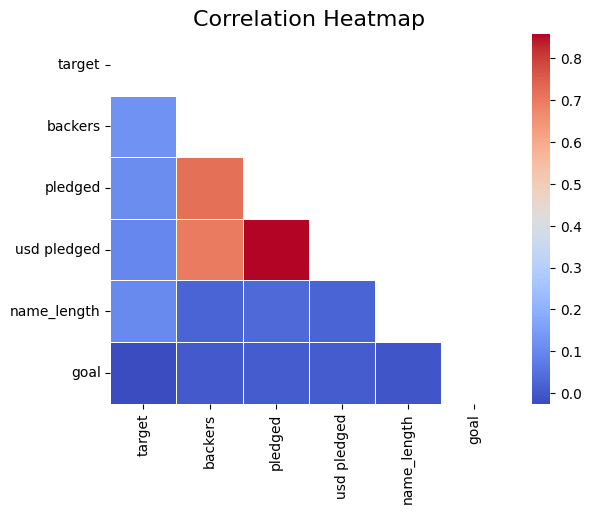

In [7]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


valid_state = ['successful', 'failed']
df_eda = df_leak[df_leak['state'].isin(valid_state)].copy()
# Replace valid state with boolean flag
df_eda['target'] = df_eda['state'].apply(lambda x: 1 if x == 'successful' else 0)

leakage_candidate = ['target', 'backers', 'pledged', 'usd pledged', 'name_length', 'goal']
corr_matrix = df_eda[leakage_candidate].corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap', fontsize=16)
plt.show()


#### Leakage

From the heatmap above, we can see flagged leakage columns are pledged, usd pledge and backers. A interesting thing here is they both have weak correlation with target, this is abnormal but can be explained. For example, a high pledged amount can still result in failure if the goal is extremely high. And both three features are unknown at the time of project launch, so they're both post-outcome features. So I decide to drop them.

Another leakage would occur is the time, we cannot use past data to predict the future data, but thankfully, we can use the deadline and launched to calculate the duration of those kickstarter projects.

Moreover, to enrich the features, I also introduce launched month and year for seasonal check.

In [8]:

# Drop 'pledged, usd pledged, backers' and wasted 'state'
df_valid = df_eda.drop(columns=['pledged', 'usd pledged', 'backers', 'state']).copy()
df_valid['deadline'] = pd.to_datetime(df_valid['deadline'])
df_valid['launched'] = pd.to_datetime(df_valid['launched'])

df_valid['duration'] = (df_valid['deadline'] - df_valid['launched']).dt.days

df_valid['launch_month'] = df_valid['launched'].dt.month
df_valid['launch_year'] = df_valid['launched'].dt.year

unique_columns = []
for column in df_valid.columns:
    unique_columns.append(column)
print(unique_columns)

display(df_valid.head(5))

['category', 'main_category', 'currency', 'deadline', 'goal', 'launched', 'country', 'name_length', 'target', 'duration', 'launch_month', 'launch_year']


,category,main_category,currency,deadline,goal,launched,country,name_length,target,duration,launch_month,launch_year
0,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,GB,31.0,0,58,8,2015
1,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,US,45.0,0,59,9,2017
2,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,US,14.0,0,44,1,2013
3,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,US,49.0,0,29,3,2012
5,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,US,20.0,1,34,2,2016


### Time-based Split

First, we drop the NaN data, then, sort the data from by lauch_year and lauch_month to prevent them from time leakage. drop the leakage data like deadline, launched.

In [14]:
df_safe = df_valid.sort_values(['launch_year', 'launch_month'])
df_safe = df_safe.dropna()

X = df_safe.drop(columns=['deadline', 'launched', 'target'])
y = df_safe['target']

split_ratio = 0.8
split_index = int(len(df_safe) * split_ratio)

X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]
